# Theory & Applications for the correlation in pairwise differences

This notebook shows the recreation of plots showing the theoretical impact of time-stratified sampling 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import linregress
import pandas as pd

import sys
sys.path.append('../../src/')
from coal_cov import *
from seg_sites_covar import CorrSegSites
from draw_demography import *
from plot_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
main_figdir = '../../plots/two_locus_stats/'
supp_figdir = '../../plots/supp_figs/two_locus_stats/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

In [3]:
def estNe(t2s):
    """Given modern estimate of t2s calculate Ne."""
    return(np.mean(t2s)/2./2.)

def plot_bot_demo(ax, N0=1e4, T_bot=100, b=0.1, **kwargs):
    """Plot bottleneck demography."""
    xs = np.arange(0, int(10*T_bot))
    ns = np.repeat(N0, xs.size)
    ns[T_bot:] = N0*b
    ax.plot(xs,ns, **kwargs)
    
def corr_bl_2_corr_pi_kb(ta, corr_bl, theta=0.4):
    """Compute the correlation in pairwise diversity using the correlation in branch length."""
    coeff = 1. / (1. + (2 + (ta /2./Ne)/theta))
    corr_pi = coeff * corr_bl
    return(corr_pi, coeff)

def linear_appx_exp_slope(rho=1e-4):
    """Compute the expected slope """
    return(-rho/2. * (rho + 12.)/(rho**2 + 13*rho + 18.))
    
def intercept_appx(rho):
    """Approximatethe intecept in the constant sized case """
    return((rho + 18.)/(rho**2 + 13.*rho+ 18.))


100%|██████████| 2/2 [00:00<00:00, 30.59it/s]


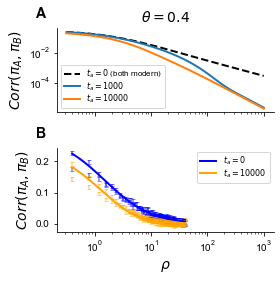

In [4]:
# Plotting just the first two plots
fig, axs = plt.subplots(2,1, figsize=(4,4), sharex=True, tight_layout=True)
# gs = fig.add_gridspec(3, 6)
ax1 = axs[0]; debox(ax1)

# Plot A: Theoretical Results
rhos2_t = 10**np.linspace(-0.5, 3, 100)
theta = 0.4
ta = 1000
Ne = 1e4
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, 0., theta=theta), 
          linestyle='--', lw=2, color='black', label=r'$t_a = 0$ (both modern)')
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, ta/Ne/2., theta=theta), 
        lw=2, label=r'$t_a = %d$' % ta)
ax1.plot(rhos2_t, TwoLocusTheoryConstant._corrSASB(rhos2_t, ta*10/Ne/2., theta=theta), 
        lw=2, label=r'$t_a = %d$' % (ta*1e1))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'$\theta = %0.1f$' % theta, fontsize=14)

ax1.legend(fontsize=8, labelspacing=-0.0)

# Plots 
ax2 = axs[1]; debox(ax2)
colors = {0:'blue', 10000:'orange'}
tas = [0,10000]
rec_rates = np.logspace(-5,-3, 1000)
Ne=1e4

#Paired Correlations 
corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()

for t in tqdm(tas):
    df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t) & (corr_s1_s2_df.L == 1000)] 
    rec_rate_mean = df.rec_rate_mean
    rec_rate_se = df.rec_rate_se
    corr_s1_s2 = df.corr_s1_s2
    se_r = df.se_corr
    ax2.errorbar(4*Ne*rec_rate_mean, corr_s1_s2, yerr=2*se_r, 
                capsize=2, ls='none', alpha=0.5, color=colors[t])
    
    ax2.plot(4*Ne*rec_rates, TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rates, ta=t/Ne/2, theta=4*Ne*1e3*1e-8), 
            zorder=10, color=colors[t], lw=2, label=r'$t_a = %d$' % t)
ax2.legend(fontsize=8, labelspacing=-0.0)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\rho$', fontsize=14)    
    
    
# Labeling all of the axes
for (axi,lbl) in zip([ax1, ax2],['A','B']):
    axi.text(-0.05, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);

ax1.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
ax2.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
  
plt.tight_layout()
plt.savefig(main_figdir + 'corr_seg_sites_theory_sims.pdf', dpi=300, bbox_inches='tight')

100%|██████████| 2/2 [00:00<00:00, 77.88it/s]


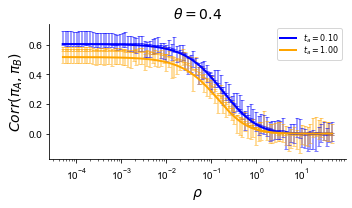

In [5]:
# Plotting just the first two plots
fig, axs = plt.subplots(1,1, figsize=(5,3), sharex=True, tight_layout=True)


# Plot A: Theoretical Results
rhos2_t = np.logspace(-4, 2, 100)
theta = 0.4
ta = 1e-1
Ne = 1.
axs.set_title(r'$\theta = %0.1f$' % theta, fontsize=14)

# Plots 
colors = {0.1:'blue', 1.0 : 'orange'}
tas = [0.10,1.0]
Ne=1e4

#Paired correlation estimates
corr_s1_s2_df = pd.read_csv('../../results/two_loci/theory_mut_corr.csv')
for t in tqdm(tas):
    df = corr_s1_s2_df[corr_s1_s2_df.ta == t] 
    rec_rate_mean = df.rec_rate
    corr_s1_s2 = df.corr_piApiB
    se_r = df.se_corr_piApiB
    axs.errorbar(rec_rate_mean/2, corr_s1_s2, yerr=2*se_r, 
                capsize=2, ls='none', alpha=0.5, color=colors[t])
    
    axs.plot(np.sort(rec_rate_mean)/2, TwoLocusTheoryConstant._corrSASB(4*np.sort(rec_rate_mean), ta=t, theta=4*0.4), 
            zorder=10, color=colors[t], lw=2, label=r'$t_a = %0.2f$' % t)
axs.legend(fontsize=10, labelspacing=-0.0)
axs.set_xscale('log')
axs.set_xlabel(r'$\rho$', fontsize=14)    
axs.legend(fontsize=8, labelspacing=-0.0)
debox(axs);
axs.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
# axs.set_xlim(1e-5,1e-1)  
plt.tight_layout()

plt.savefig(main_figdir + 'corr_seg_sites_theory_sims_fixed.pdf', dpi=300, bbox_inches='tight')

## The effect of demography on the correlation in branch length

100%|██████████| 3/3 [00:00<00:00, 144.07it/s]


Ne (Constant-Size): 5069.94
Ne (Constant-Size): 10054.84
Ne (Constant-Size): 20080.01
Ne (Tennessen Model) : 6922.91
Ne (Browning Model): 2670.19
Ne (Instant Growth 7): 168.13
Ne (Instant Growth 8): 183.60
Ne (Instant Growth 9): 243.28


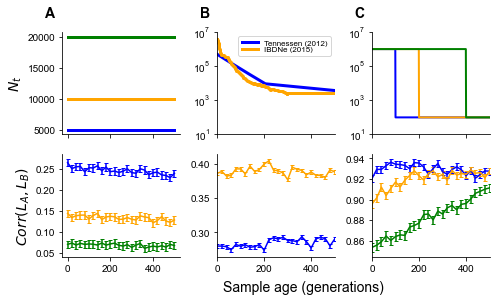

In [6]:
## ------ Figure of correlation in branch length in various demographies  ------- ##
fig, axs = plt.subplots(2,3, figsize=(7, 4), sharex='col')

# Part 1: Constant population size
ax3 = axs[0,0]; debox(ax3)
ax4 = axs[1,0]; debox(ax4)

# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# compute the asymptotic standard errors (Note - these are similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
    print("Ne (Constant-Size): %0.2f" % Ne_hat)
    
    ax3.plot(tas, np.repeat(n,tas.size), lw=3, color=colors[i])
    # Note - this is a fixed theta here ... 
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    rho = 2*Ne_hat*1e-4
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    ax4.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1


ax5 = axs[0,1]; debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e1,1e7)
ax5.set_xlim(0, 500)
ax5.legend(fontsize=8, labelspacing=-0.0)

ax6 = axs[1,1]; debox(ax6)

# Plot the Tennessen et al model...
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
mean_et2 = np.mean(cur_df.exp_bl)
Ne_hat = mean_et2/2./2.
print('Ne (Tennessen Model) : %0.2f' % Ne_hat)
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
# ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


# Plot the UK10K results
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
mean_et2 = np.mean(cur_df.exp_bl)
Ne_hat = mean_et2/2./2.
print('Ne (Browning Model): %0.2f' % Ne_hat)
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
# ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
ax6.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


ax7 = axs[0,2]; debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_ylim(1e1,1e7)
ax7.set_xlim(0,500)
    
ax8 = axs[1,2]; debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.
    print("Ne (Instant Growth %d): %0.2f" % (x, Ne_hat))
    theta = 4 * Ne_hat * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    ax8.errorbar(cur_df.ta, cur_df.corr_bl, yerr=2*cur_df.se_r, capsize=2, color=colors[i])
    i += 1

    
# Labeling all of the axes
for (axi,lbl) in zip([axs[0,0], axs[0,1], axs[0,2]],['A','B','C']):
    axi.text(-0.06, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);


axs[0,0].set_ylabel(r'$N_t$', fontsize=14)
axs[1,0].set_ylabel(r'$Corr(L_A,L_B)$', fontsize=14)
plt.tight_layout()

fig.text(0.45, -0.025, r'Sample age (generations)', fontsize=14)
plt.savefig(main_figdir + 'full_demography.corr_branch_len.pdf', dpi=300, bbox_inches='tight')

In [7]:
# Checking the linear approximation for constant-size
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# Compute the asymptotic standard errors (Note - these are very similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in Ns:
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.

    # Note - this is a fixed theta here ...
    rho = 4*(2*cur_df.Ne.values[0])*1e-4
    print("Predicted Slope: %0.4f; Predicted Intercept: %0.4f"% (linear_appx_exp_slope(rho), intercept_appx(rho)))
    slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), cur_df.corr_bl)
    print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
    # Verify that the product of ta*rho << 1
    print("ta * rho: %0.4f" % (np.max(cur_df.ta)/(2.*n) * rho))
    print("")

Predicted Slope: -0.3721; Predicted Intercept: 0.2558
Estimated Slope: -0.4289; Estimated Intercept: 0.2571; p-value: 0.000001
ta * rho: 0.2000

Predicted Slope: -0.4301; Predicted Intercept: 0.1398
Estimated Slope: -0.5194; Estimated Intercept: 0.1405; p-value: 0.000213
ta * rho: 0.2000

Predicted Slope: -0.4647; Predicted Intercept: 0.0705
Estimated Slope: -0.5267; Estimated Intercept: 0.0724; p-value: 0.001848
ta * rho: 0.2000



In [8]:
# Checking the linear approximation for constant-size
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# Compute the asymptotic standard errors (Note - these are very similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in Ns:
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    Ne_hat = mean_et2/2./2.

    # Note - this is a fixed theta here ...
    rho = 4*(2*cur_df.Ne.values[0])*1e-4
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
#     print(coeff)
    print("Predicted Slope: %0.4f; Predicted Intercept: %0.4f"% (linear_appx_exp_slope(rho), intercept_appx(rho)))
    slope, intercept, _, pval, stderr = linregress(cur_df.ta/(2.*cur_df.Ne.values[0]), corr_pi)
    print("Estimated Slope: %0.4f; Estimated Intercept: %0.4f; p-value: %0.6f" % (slope, intercept, pval))
    # Verify that the product of ta*rho << 1
    print("ta * rho: %0.4f" % (np.max(cur_df.ta)/(2.*n) * rho))
    print("")

Predicted Slope: -0.3721; Predicted Intercept: 0.2558
Estimated Slope: -0.2058; Estimated Intercept: 0.0856; p-value: 0.000000
ta * rho: 0.2000

Predicted Slope: -0.4301; Predicted Intercept: 0.1398
Estimated Slope: -0.2078; Estimated Intercept: 0.0468; p-value: 0.000020
ta * rho: 0.2000

Predicted Slope: -0.4647; Predicted Intercept: 0.0705
Estimated Slope: -0.1937; Estimated Intercept: 0.0241; p-value: 0.000705
ta * rho: 0.2000



## The effect of demography on the correlation in pairwise differences

100%|██████████| 3/3 [00:00<00:00, 140.69it/s]


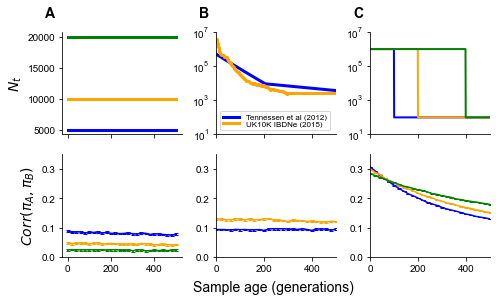

In [9]:
## ------ Testing figure  ------- ##
fig, axs = plt.subplots(2,3, figsize=(7, 4), sharex='col')

# Part 1: Constant population size
ax3 = axs[0,0]; debox(ax3)
ax4 = axs[1,0]; debox(ax4)

# Loading in the metadata for correlation in branch length
corr_bl_df = pd.read_csv('../../results/two_loci/multi_scenario_branch_len.csv')
corr_bl_df = corr_bl_df.dropna()

# compute the asymptotic standard errors (Note - these are similar to bootstrapped values) 
corr_bl_df['se_r'] = np.sqrt((1. - corr_bl_df.corr_bl.values ** 2) / (corr_bl_df.Nreps.values - 2.))

# Plotting constant tests
Ns = [5000,10000,20000]
colors = ['blue','orange', 'green']
mu = 1e-8
# This is what we have simulated ... 
tas = np.arange(0,501,50)
i = 0
for n in tqdm(Ns):
    cur_df = corr_bl_df[(corr_bl_df.Ne == n) & (corr_bl_df.scenario == 'SerialConstant')]
    # use the pairwise times to approximate Ne
    mean_et2 = np.mean(cur_df.exp_bl)
    
    ax3.plot(tas, np.repeat(n,tas.size), lw=3, color=colors[i])
    # Note - this is a fixed theta here ... 
    theta = 4 * cur_df.Ne.values[0] * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    # Note - we linearly scale the standard error here ... 
    ax4.errorbar(cur_df.ta, corr_pi,  yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    i += 1


ax5 = axs[0,1]; debox(ax5)
# Plot both demographies
demo_model1_file = {'Tennessen et al (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'UK10K IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    ax5.plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
ax5.set_yscale('log')
ax5.set_ylim(1e1,1e7)
ax5.set_xlim(0, 500)
ax5.legend(fontsize=8, labelspacing=-0.0)


ax6 = axs[1,1]; debox(ax6)

# Plot the Tennessen et al model...
i = 0
cur_df = corr_bl_df[corr_bl_df.scenario == 'Tennessen']
mean_et2 = np.mean(cur_df.exp_bl)
# Ne_hat = mean_et2/2./2.
Ne_hat = cur_df.Ne_est.values[0]
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])

# Plot the UK10K results
i = 1
cur_df = corr_bl_df[corr_bl_df.scenario == 'IBDNeUK10K']
mean_et2 = np.mean(cur_df.exp_bl)
# Ne_hat = mean_et2/2./2.
Ne_hat = cur_df.Ne_est.values[0]
# Ne_hat = 1e4
theta = 4 * Ne_hat * 1e3 * 1e-8
corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
ax6.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])


ax7 = axs[0,2]; debox(ax7)
tbot = [100,200,400]
i = 0
for tb in tbot:
    plot_bot_demo(ax7, N0=1e6, T_bot=tb, b=0.0001, lw=2, color=colors[i])
    i += 1

ax7.set_yscale('log')
ax7.set_ylim(1e1,1e7)
ax7.set_xlim(0,500)
    
ax8 = axs[1,2]; debox(ax8)
i = 0 
for x in tqdm([7,8,9]):
    
    cur_df = corr_bl_df[corr_bl_df.scenario == 'InstantGrowth%d' % x]
    mean_et2 = np.mean(cur_df.exp_bl)
#     Ne_hat = mean_et2/2./2.
    Ne_hat = cur_df.Ne_est.values[0]
    theta = 4 * Ne_hat * 1e3 * 1e-8
    corr_pi, coeff = corr_bl_2_corr_pi_kb(cur_df.ta, theta=theta, corr_bl=cur_df.corr_bl)
    ax8.errorbar(cur_df.ta, corr_pi, yerr=2*cur_df.se_r*coeff, capsize=2, color=colors[i])
    i += 1

    
    
# Labeling all of the axes
for (axi,lbl) in zip([axs[0,0], axs[0,1], axs[0,2]],['A','B','C']):
    axi.text(-0.06, 1.25, lbl, fontsize=14, 
               fontweight='bold', va='top', ha='right', transform=axi.transAxes);


# Setting the y-limit to make things more comparable on bottom row
for x in axs[1,:]:
    x.set_ylim(0,0.35);
    
    
axs[0,0].set_ylabel(r'$N_t$', fontsize=14)
axs[1,0].set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
plt.tight_layout()

fig.text(0.55, -0.025, r'Sample age (generations)', ha='center', fontsize=14)
plt.savefig(main_figdir + 'full_demography.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')

## Comparing correlation in pairwise differences under two demographic models

In [10]:
test_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
test_df.head()

,scenario,N,ta,L,rec_rate_mean,rec_rate_se,corr_s1_s2,se_corr,seed,Ne
0,SerialConstant,200,0,1000,0.00001,1.549490e-09,0.226360,0.003080,42,10000
1,SerialConstant,200,0,1000,0.00002,2.102783e-09,0.198395,0.003099,42,10000
2,SerialConstant,200,0,1000,0.00003,2.398451e-09,0.158905,0.003122,42,10000
3,SerialConstant,200,0,1000,0.00004,2.606499e-09,0.126981,0.003137,42,10000
4,SerialConstant,200,0,1000,0.00005,2.734551e-09,0.122383,0.003139,42,10000


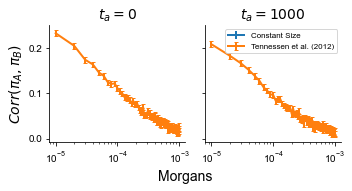

In [11]:

filt_df1 = test_df[(test_df.scenario == 'SerialConstant') & (test_df.Ne == 6958) & (test_df.ta == 0) & (test_df.seed == 42)]
filt_df2 = test_df[(test_df.scenario == 'TennessenEuropean') & (test_df.Ne == 10000) & (test_df.ta == 0) & (test_df.seed == 42)]

fig, ax = plt.subplots(1,2,figsize=(5,2.5), sharex=True, sharey=True)
ax[0].errorbar(filt_df1.rec_rate_mean, filt_df1.corr_s1_s2, 
            yerr=2*filt_df1.se_corr, capsize=2, lw=2, label=r'Constant Size')

ax[0].errorbar(filt_df2.rec_rate_mean, filt_df2.corr_s1_s2, 
            yerr=2*filt_df2.se_corr, capsize=2, lw=2, label=r'Tennessen et al. (2012)')
ax[0].set_xscale('log')
ax[0].set_title(r'$t_a = %d$' % 0, fontsize=14)

# Making the plot with new timepoints
filt_df1 = test_df[(test_df.scenario == 'SerialConstant') & (test_df.Ne == 6958) & (test_df.ta == 1000) & (test_df.seed == 42)]
filt_df2 = test_df[(test_df.scenario == 'TennessenEuropean') & (test_df.Ne == 10000) & (test_df.ta == 1000) & (test_df.seed == 42)]

ax[1].errorbar(filt_df1.rec_rate_mean, filt_df1.corr_s1_s2, 
            yerr=2*filt_df1.se_corr, capsize=2, lw=2, label=r'Constant Size')

ax[1].errorbar(filt_df2.rec_rate_mean, filt_df2.corr_s1_s2, 
            yerr=2*filt_df2.se_corr, capsize=2, lw=2, label=r'Tennessen et al. (2012)')

ax[1].set_title(r'$t_a = %d$' % 1000, fontsize=14)


# Plotting aesthetics 
debox(ax[0]); debox(ax[1]);
ax[1].legend(fontsize=8)

# Setting labels
ax[0].set_ylabel(r'$Corr(\pi_A,\pi_B)$',fontsize=14);
fig.text(0.45, -0.025, r'Morgans', fontsize=14);
plt.savefig(supp_figdir + 'demo_test_v_constant.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')

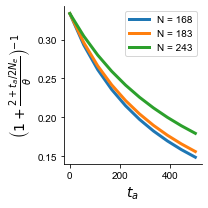

In [12]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
Nes = [168.13, 183.60, 243.28]
tas = np.linspace(0,501,10)
for n in Nes:
    theta = 4 * n * 1e-8 * 1e3
    coeff = 1. / (1. + (2 + (tas /2./Ne)/theta))
    ax.plot(tas, coeff, lw=3, label=r'N = %d' %n)
ax.legend()
ax.set_ylabel(r'$\left(1 + \frac{2 + t_a/2N_e}{\theta}\right)^{-1}$', fontsize=14);
ax.set_xlabel(r'$t_a$', fontsize=14);
debox(ax);
plt.savefig(supp_figdir + 'coefficient.corr_piA_piB.pdf', dpi=300, bbox_inches='tight')

## Correlation in $Corr(\pi_A, \pi_B)$ for new Monte-Carlo Scheme

In [13]:
corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.v2.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()
corr_s1_s2_df.head()

,scenario,N,ta,L,rec_rate_mean,rec_rate_se,corr_s1_s2,se_corr,seed,Ne
0,SerialConstant,200,0,1000,1.217214e-07,1.351064e-08,0.228943,0.001313,24,10000
1,SerialConstant,200,0,1000,1.792435e-07,2.009360e-08,0.227912,0.001313,24,10000
2,SerialConstant,200,0,1000,2.622535e-07,2.910196e-08,0.229509,0.001313,24,10000
3,SerialConstant,200,0,1000,3.861496e-07,4.327915e-08,0.226963,0.001313,24,10000
4,SerialConstant,200,0,1000,5.649834e-07,6.270916e-08,0.224989,0.001314,24,10000


100%|██████████| 1/1 [00:00<00:00, 178.22it/s]


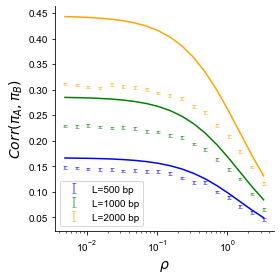

In [14]:
# Plotting just the first two plots
fig, ax = plt.subplots(1,1, figsize=(4,4), tight_layout=True)

# # Plot A: Theoretical Results
rhos2_t = 10**np.linspace(-2.5, 2, 100)
ta = 10000
Ne = 1e4
theta = 4*Ne*1e3*1e-8

tas = [0]
rec_rates = np.logspace(-7,-2, 1000)
Ne=1e4



#Paired Correlations 
corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.v2.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()
Ls = np.unique(corr_s1_s2_df.L.values)
i = 0
colors = ['blue', 'green', 'orange']
for L in Ls:
    for t in tqdm(tas):
        cur_theta = 4. * Ne * L * 1e-8
        df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t) & (corr_s1_s2_df.L == L)] 
        rec_rate_mean = df.rec_rate_mean
        rec_rate_se = df.rec_rate_se
        corr_s1_s2 = df.corr_s1_s2
        se_r = df.se_corr
        ax.errorbar(4*Ne*rec_rate_mean, corr_s1_s2, yerr=2*se_r, 
                    capsize=2, ls='none', alpha=0.5, color=colors[i], label='L=%d bp' % L)
    
    # The estimate of Ne    
    ax.plot(4*Ne*rec_rate_mean, 
            TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rate_mean, ta=t/Ne/2., theta=cur_theta), 
            color=colors[i], zorder=10)
    i += 1


debox(ax);
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$', fontsize=14)    
ax.legend()
ax.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
plt.tight_layout();

100%|██████████| 1/1 [00:00<00:00, 116.14it/s]


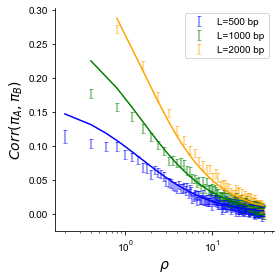

In [15]:
# Plotting just the first two plots
fig, ax = plt.subplots(1,1, figsize=(4,4), tight_layout=True)

# # Plot A: Theoretical Results
rhos2_t = 10**np.linspace(-2.5, 2, 100)
ta = 10000
Ne = 1e4
theta = 4*Ne*1e3*1e-8

tas = [0]
rec_rates = np.logspace(-7,-2, 1000)
Ne=1e4

#Paired Correlations 
corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()
Ls = np.unique(corr_s1_s2_df.L.values)
i = 0
colors = ['blue', 'green', 'orange']
for L in Ls:
    for t in tqdm(tas):
        cur_theta = 4. * Ne * L * 1e-8
        df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t) & (corr_s1_s2_df.L == L) & (corr_s1_s2_df.seed == 24)] 
        rec_rate_mean = df.rec_rate_mean
        rec_rate_se = df.rec_rate_se
        corr_s1_s2 = df.corr_s1_s2
        se_r = df.se_corr
        ax.errorbar(4*Ne*rec_rate_mean, corr_s1_s2, yerr=2*se_r, 
                    capsize=2, ls='none', alpha=0.5, color=colors[i], label='L=%d bp' % L)
    
    # The estimate of Ne    
    ax.plot(4*Ne*rec_rate_mean, 
            TwoLocusTheoryConstant._corrSASB(4*Ne*rec_rate_mean, ta=t/Ne/2., theta=cur_theta), 
            color=colors[i], zorder=10)
    i += 1


debox(ax);
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$', fontsize=14)    
ax.legend()
ax.set_ylabel(r'$Corr(\pi_A, \pi_B)$', fontsize=14)
plt.tight_layout();

Theta_Pred: 0.17, Theta_Exp: 0.20, L: 500 bp
Theta_Pred: 0.30, Theta_Exp: 0.40, L: 1000 bp
Theta_Pred: 0.47, Theta_Exp: 0.80, L: 2000 bp


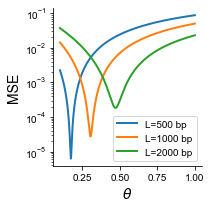

In [16]:
fig, ax =plt.subplots(1,1,figsize=(3,3))
thetas = np.logspace(-1, 0, 10000)

def resid_prediction_real(rec_rate, corr_s1_s2, Ne=1e4, ta=0, theta=0.4):
    pred_corr_s1_s2 = TwoLocusTheoryConstant._corrSASB(4.*Ne*rec_rate, ta=ta/Ne/2., theta=theta)
    mse = np.mean((corr_s1_s2 - pred_corr_s1_s2)**2)
    return(mse)

corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.v2.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()

for L in Ls:
    df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t) & (corr_s1_s2_df.L == L)] 
    rec_rate_mean = df.rec_rate_mean
    rec_rate_se = df.rec_rate_se
    corr_s1_s2 = df.corr_s1_s2
    se_r = df.se_corr

    mse = [resid_prediction_real(rec_rate_mean.values, corr_s1_s2.values, theta=t) for t in thetas]
    print("Theta_Pred: %0.2f, Theta_Exp: %0.2f, L: %d bp" % (thetas[np.argmin(mse)], 4*1e4*L*1e-8, L))
    ax.plot(thetas, mse, lw=2, label = 'L=%d bp' % L)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel(r'MSE', fontsize=14)
ax.set_xlabel(r'$\theta$', fontsize=14)
debox(ax);

Theta_Pred: 0.18, Theta_Exp: 0.20, L: 500 bp
Theta_Pred: 0.37, Theta_Exp: 0.40, L: 1000 bp
Theta_Pred: 0.86, Theta_Exp: 0.80, L: 2000 bp


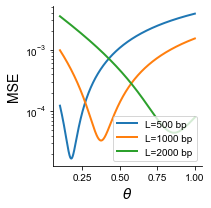

In [17]:
fig, ax =plt.subplots(1,1,figsize=(3,3))
thetas = np.logspace(-1, 0, 10000)

corr_s1_s2_df = pd.read_csv('../../results/corr_seg_sites/monte_carlo_sims_sA_sB_demography.csv')
corr_s1_s2_df = corr_s1_s2_df.dropna()

for L in Ls:
    df = corr_s1_s2_df[(corr_s1_s2_df.scenario == 'SerialConstant') & (corr_s1_s2_df.ta == t) & (corr_s1_s2_df.L == L)] 
    rec_rate_mean = df.rec_rate_mean
    rec_rate_se = df.rec_rate_se
    corr_s1_s2 = df.corr_s1_s2
    se_r = df.se_corr

    mse = [resid_prediction_real(rec_rate_mean.values, corr_s1_s2.values, theta=t) for t in thetas]
    print("Theta_Pred: %0.2f, Theta_Exp: %0.2f, L: %d bp" % (thetas[np.argmin(mse)], 4*1e4*L*1e-8, L))
    ax.plot(thetas, mse, lw=2, label = 'L=%d bp' % L)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel(r'MSE', fontsize=14)
ax.set_xlabel(r'$\theta$', fontsize=14)
debox(ax);